In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetV2B0  # Using smaller B0 instead of B1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [3]:
images = []
labels = []
path='/kaggle/input/imagesoasis'
for subfolder in tqdm(os.listdir(path)):
    subfolder_path = os.path.join(path, subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


,image,label
0,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
1,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
2,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
3,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
4,/kaggle/input/imagesoasis/Data/Non Demented/OA...,Non Demented
...,...,...
86432,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86433,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86434,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia
86435,/kaggle/input/imagesoasis/Data/Mild Dementia/O...,Mild Dementia


In [4]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [5]:
data = []
result = []
for s in non_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
        
for s in mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for s in moderate_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for s in very_mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [6]:
X = np.array(data)
y = np.array(result).reshape(len(result), 4)
y = np.argmax(y, axis=1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [9]:
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.1)
])

In [10]:
input_tensor = Input(shape=(128, 128, 3))
augmented = data_augmentation(input_tensor)

base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=augmented)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Architecture
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [12]:
print("Phase 1: Training with frozen base model")
history_phase1 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)



Phase 1: Training with frozen base model
Epoch 1/15


2025-04-13 19:13:19.136129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1729/1729 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.6817 - loss: 0.8983 - val_accuracy: 0.7816 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 2/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.7788 - loss: 0.5674 - val_accuracy: 0.7763 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 3/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.7837 - loss: 0.5380 - val_accuracy: 0.7843 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 4/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.7875 - loss: 0.5255 - val_accuracy: 0.7975 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 5/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.7843 - loss: 0.5221 - val_accuracy: 0.8067 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 6/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.7922 - loss: 0.5122 - val_accuracy: 0.8009 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 7/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.7982 

In [13]:
import gc
gc.collect()


752

In [14]:
print("Phase 2: Fine-tuning the model")
# Unfreeze the last 30% of the base model
for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
    layer.trainable = False
for layer in base_model.layers[int(len(base_model.layers)*0.8):]:
    layer.trainable = True

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Phase 2: Fine-tuning the model


In [15]:
history_phase2 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


2025-04-13 19:26:33.167088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3458/3458 ━━━━━━━━━━━━━━━━━━━━ 127s 32ms/step - accuracy: 0.7853 - loss: 0.5433 - val_accuracy: 0.8223 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Epoch 2/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 106s 31ms/step - accuracy: 0.8102 - loss: 0.4611 - val_accuracy: 0.8239 - val_loss: 0.4050 - learning_rate: 1.0000e-04
Epoch 3/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 107s 31ms/step - accuracy: 0.8180 - loss: 0.4417 - val_accuracy: 0.8422 - val_loss: 0.3651 - learning_rate: 1.0000e-04
Epoch 4/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 106s 31ms/step - accuracy: 0.8256 - loss: 0.4243 - val_accuracy: 0.8453 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 5/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 107s 31ms/step - accuracy: 0.8310 - loss: 0.4071 - val_accuracy: 0.8602 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 6/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 107s 31ms/step - accuracy: 0.8411 - loss: 0.3875 - val_accuracy: 0.8583 - val_loss: 0.3358 - learning_rate: 1.0000e-04
Epoch 7/20
3458/3458 ━━━━━━━━━━━━━━━━━━━━ 107

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

541/541 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9247 - loss: 0.1988
Test accuracy: 92.43%
Test loss: 0.1986


In [17]:
gc.collect()


1138

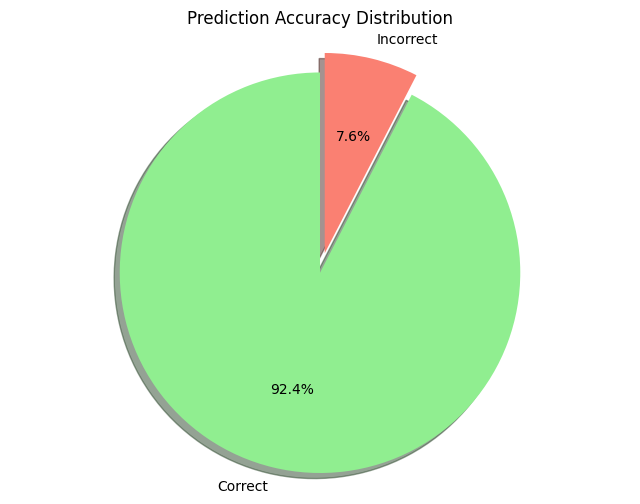

In [19]:
correct_predictions = np.sum(y_test == y_pred)
incorrect_predictions = np.sum(y_test != y_pred)

plt.figure(figsize=(8, 6))
plt.pie([correct_predictions, incorrect_predictions], explode=(0.1, 0), labels=['Correct', 'Incorrect'],
        colors=['lightgreen', 'salmon'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Prediction Accuracy Distribution')
plt.show()

In [ ]:
print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)